Transformers vs. LSTM for Stock Price Time Series Prediction 
https://medium.com/@mskmay66/transformers-vs-lstm-for-stock-price-time-series-prediction-3a26fcc1a782

Prediction of Stock Price Time Series using Transformers Lorenzo D. Costa1, Alexei M. C. Machado August 2023
https://www.researchgate.net/publication/372947061_Prediction_of_Stock_Price_Time_Series_using_Transformers

Stock Price Forecast: Comparison of LSTM, HMM, and Transformer Qianzhun Wang1(B) and Yingqing Yuan2
https://www.researchgate.net/publication/372632831_Stock_Price_Forecast_Comparison_of_LSTM_HMM_and_Transformer

Test another transformers model

testing againt

In [4]:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import layers
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import time
import timeit
from datetime import datetime


class ETL:
    """
    ticker: str
    period: string
    test_size: float betwee 0 and 1
    n_input: int
    timestep: int
    Extracts data for stock with ticker `ticker` from yf api,
    splits the data into train and test sets by date,
    reshapes the data into np.array of shape [#weeks, 5, 1],
    converts our problem into supervised learning problem.
    """

    def __init__(self, datainput, test_size=0.2, n_input=5, timestep=5, normalize_bool=False, scaler=None) -> None:
        self.datainput = datainput
        self.test_size = test_size
        self.n_input = n_input
        self.timestep = timestep
        self.normalize_bool = normalize_bool
        self.scaler = scaler
        self.df = self.extract_historic_data()
        self.train, self.test = self.etl()
        self.X_train, self.y_train = self.to_supervised(self.train)
        self.X_test, self.y_test = self.to_supervised(self.test)

        if self.normalize_bool:
            print('normalized', normalize_bool)
            self.scaler = scaler
        else:
            print('not normalized', normalize_bool)
            self.scaler = None

    def extract_historic_data(self) -> pd.Series:
        """
        Extracts historic data and optionally normalizes it.
        """
        data = self.datainput
        if self.normalize_bool:
            data = self.scaler.fit_transform(data.values.reshape(-1, 1))
        return data

    def split_data(self) -> tuple:
        """
        Splits our pd.Series into train and test series with
        test series representing test_size * 100 % of data.
        """
        # data = self.extract_historic_data()
        data = self.df
        if len(data) != 0:
            train_idx = round(len(data) * (1-self.test_size))
            train = data[:train_idx]
            test = data[train_idx:]
            train = np.array(train)
            test = np.array(test)
            return train[:, np.newaxis], test[:, np.newaxis]
        else:
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into shape our model needs,
        namely, [# samples, timestep, # feautures]
        samples
        """
        NUM_FEATURES = 1
        samples = int(data.shape[0] / self.timestep)
        result = np.array(np.array_split(data, samples))
        output = result.reshape((samples, self.timestep, NUM_FEATURES))
        print(output.shape)
        return output

    def transform(self, train, test) -> np.array:
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0 and test_remainder != 0:
            train = train[train_remainder:]
            test = test[test_remainder:]
        elif train_remainder != 0:
            train = train[train_remainder:]
        elif test_remainder != 0:
            test = test[test_remainder:]
        # print("train:", train, "test:", test)
        return self.window_and_reshape(train), self.window_and_reshape(test)

    def etl(self) -> tuple[np.array, np.array]:
        """
        Runs complete ETL
        """
        train, test = self.split_data()
        return self.transform(train, test)

    def to_supervised(self, train, n_out=5) -> tuple:
        """
        Converts our time series prediction problem to a
        supervised learning problem.
        """
        # flatted the data
        data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
        X, y = [], []
        in_start = 0
        # step over the entire history one time step at a time
        for _ in range(len(data)):
            # define the end of the input sequence
            in_end = in_start + self.n_input
            out_end = in_end + n_out
            # ensure we have enough data for this instance
            if out_end <= len(data):
                x_input = data[in_start:in_end, 0]
                x_input = x_input.reshape((len(x_input), 1))
                X.append(x_input)
                y.append(data[in_end:out_end, 0])
                # move along one time step
                in_start += 1
        print(np.array(X), np.array(y))
        return np.array(X), np.array(y)

# *******************************
# Implementing a Transformer


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2, epsilon=1e-6, attention_axes=None, kernel_size=1):
    """
    Creates a single transformer block.
    """
    x = layers.LayerNormalization(epsilon=epsilon)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout,
        attention_axes=attention_axes
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=epsilon)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size,
                      activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
    return x + res


def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0.2, mlp_dropout=0.2, attention_axes=None, epsilon=1e-6, kernel_size=1):
    """
    Creates final model by building many transformer blocks.
    """
    n_timesteps, n_features, n_outputs = 5, 1, 5
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))
    x = inputs
    for _ in range(num_trans_blocks):
        x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim,
                                dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(n_outputs)(x)
    return tf.keras.Model(inputs, outputs)


def fit_transformer(transformer: tf.keras.Model, x_train, y_train, X_val, y_val, display_loss=False):
    """
    Compiles and fits our transformer.
    """
    transformer.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["mae", 'mape'])

    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='loss', patience=10, restore_best_weights=True)]
    start = time.time()
    # hist = transformer.fit(data.X_train, data.y_train, batch_size=32, epochs=25, verbose=1, callbacks=callbacks)
    hist = transformer.fit(x_train, y_train, validation_data=(
        X_val, y_val), batch_size=32, epochs=25, verbose=1, callbacks=callbacks)
    print("time used", time.time() - start)
    history_df = pd.DataFrame(hist.history)

    if display_loss:
        history_df['loss'].plot()
        plt.title('Training Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train'], loc='upper right')
        plt.show()
        history_df['val_loss'].plot()
        plt.title('Validation Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Validation'], loc='upper right')
        plt.show()

        # Display minimum validation loss
        min_val_loss = history_df['val_loss'].min()
        print("Minimum validation loss: {:.4f}".format(min_val_loss))
        # Plot mae
        history_df.loc[:, ['mae', 'val_mae']].plot()
        plt.title('Model MAE')
        plt.ylabel('MAE')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()
        # Display minimum validation mae and mape
        min_val_mae = history_df['val_mae'].min()
        min_val_mape = history_df['val_mape'].min()
        print("Minimum validation MAE: {:.4f}".format(min_val_mae))
        print("Minimum validation MAPE: {:.4f}".format(min_val_mape))

    return hist

# **********************


class PredictAndForecast:
    """
    model: tf.keras.Model
    train: np.array
    test: np.array
    Takes a trained model, train, and test datasets and returns predictions
    of len(test) with same shape.
    """

    def __init__(self, model, train, test, n_input=5, scaler=None, normalize_bool=False) -> None:
        self.model = model
        self.train = train
        self.test = test
        self.n_input = n_input
        self.scaler = scaler
        self.normalize_bool = normalize_bool
        self.predictions = self.get_predictions()

    def forecast(self, history) -> np.array:
        """
        Given last weeks actual data, forecasts next weeks prices.
        """
        # flatten data
        data = np.array(history)
        data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
        # retrieve last observations for input data
        input_x = data[-self.n_input:, :]
        # reshape into [1, n_input, 1]
        input_x = input_x.reshape((1, len(input_x), input_x.shape[1]))
        # forecast the next week
        yhat = self.model.predict(input_x, verbose=0)
        # we only want the vector forecast
        yhat = yhat[0]
        return yhat

    def get_predictions(self) -> np.array:
        """
        compiles models predictions week by week over entire
        test set.
        """
        # history is a list of weekly data
        history = [x for x in self.train]
        # walk-forward validation over each week
        predictions = []
        for i in range(len(self.test)):
            yhat_sequence = self.forecast(history)
            # store the predictions
            predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
            history.append(self.test[i, :])
        predictions = np.array(predictions)
        if self.normalize_bool:
            # Inverse transform to get back to original scale
            predictions = self.scaler.inverse_transform(
                predictions.reshape(-1, 1)).reshape(predictions.shape)
            print("normalization convert active")
        return predictions


class Evaluate:

    def __init__(self, actual, predictions) -> None:
        self.actual = actual
        self.predictions = predictions
        self.var_ratio = self.compare_var()
        self.mape = self.evaluate_model_with_mape()
        self.rmse = self.evaluate_model_with_rmse()
        self.mae = self.evaluate_model_with_mae()
        self.r2 = self.evaluate_model_with_r2()

    def compare_var(self):
        return abs(1 - (np.var(self.predictions) / np.var(self.actual)))

    def evaluate_model_with_mape(self):
        return mean_absolute_percentage_error(self.actual.flatten(), self.predictions.flatten())

    def evaluate_model_with_rmse(self):
        return root_mean_squared_error(self.actual.flatten(), self.predictions.flatten())

    def evaluate_model_with_mae(self):
        return mean_absolute_error(self.actual.flatten(), self.predictions.flatten())

    def evaluate_model_with_r2(self):
        return r2_score(self.actual.flatten(), self.predictions.flatten())


def plot_results(train, test, preds, df, title_suffix=None, xlabel='AAPL stock Price'):
    """
    Plots training data in blue, actual values in red, and predictions in green,
    over time.
    """

    fig, ax = plt.subplots(figsize=(20, 6))
    # x = df.Close[-498:].index
    plot_test = test[1:]
    plot_preds = preds[1:]

    # x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index
    plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
    plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
    plot_train = train.reshape((train.shape[0]*train.shape[1], 1))
    print(f'plot_train shape: {plot_train.shape}')
    print(f'plot_test shape: {plot_test.shape}')
    print(f'plot_preds shape: {plot_preds.shape}')

    # x_train = df[:len(plot_train)].index
    # x_test = df[len(plot_train):len(plot_train) + len(plot_test)].index

    x_train = df[:len(plot_train)]
    x_test = df[len(plot_train):len(plot_train) + len(plot_test)]

    ax.plot(x_train, plot_train, label='Train', color='blue')
    ax.plot(x_test, plot_test, label='actual', color='red')
    ax.plot(x_test, plot_preds, label='preds', color='green')
    if title_suffix == None:
        ax.set_title('Predictions vs. Actual')
    else:
        ax.set_title(f'Predictions vs. Actual, {title_suffix}')
    ax.set_xlabel('Date')
    ax.set_ylabel(xlabel)
    ax.legend()
    plt.show()

[*********************100%%**********************]  1 of 1 completed

(1393, 5, 1)
(348, 5, 1)
[[[ 0.332589  ]
  [ 0.33482099]
  [ 0.33593801]
  [ 0.33705401]
  [ 0.339286  ]]

 [[ 0.33482099]
  [ 0.33593801]
  [ 0.33705401]
  [ 0.339286  ]
  [ 0.33593801]]

 [[ 0.33593801]
  [ 0.33705401]
  [ 0.339286  ]
  [ 0.33593801]
  [ 0.32142901]]

 ...

 [[39.09749985]
  [39.70249939]
  [40.02000046]
  [40.26499939]
  [38.83000183]]

 [[39.70249939]
  [40.02000046]
  [40.26499939]
  [38.83000183]
  [39.36999893]]

 [[40.02000046]
  [40.26499939]
  [38.83000183]
  [39.36999893]
  [39.96250153]]] [[ 0.33593801  0.32142901  0.308036    0.308036    0.30580401]
 [ 0.32142901  0.308036    0.308036    0.30580401  0.31138399]
 [ 0.308036    0.308036    0.30580401  0.31138399  0.296875  ]
 ...
 [39.36999893 39.96250153 40.40000153 40.23749924 39.46500015]
 [39.96250153 40.40000153 40.23749924 39.46500015 39.375     ]
 [40.40000153 40.23749924 39.46500015 39.375      39.30250168]]
[[[ 39.99499893]
  [ 39.81750107]
  [ 39.96500015]
  [ 40.36750031]
  [ 40.72750092]]

 [[ 39

218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 27.0686 - mae: 2.0455 - mape: 69.3310 - val_loss: 24.7221 - val_mae: 3.5547 - val_mape: 3.1609
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0296 - mae: 0.4708 - mape: 10.8361 - val_loss: 35.7687 - val_mae: 4.5047 - val_mape: 4.0285
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7583 - mae: 0.4113 - mape: 10.5494 - val_loss: 24.7544 - val_mae: 3.6987 - val_mape: 3.2993
Epoch 4/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6249 - mae: 0.3727 - mape: 10.7368 - val_loss: 19.3389 - val_mae: 3.0926 - val_mape: 2.7495
Epoch 5/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6384 - mae: 0.3737 - mape: 10.9392 - val_loss: 19.4904 - val_mae: 3.0761 - val_mape: 2.7390
Epoch 6/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4812 - mae: 0.3291 - mape: 9.6925 - val_loss: 20.0920 - val_mae: 3.2513 - val_mape: 2.8978
Epoch 7/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4504 - mae: 0.3237 - mape

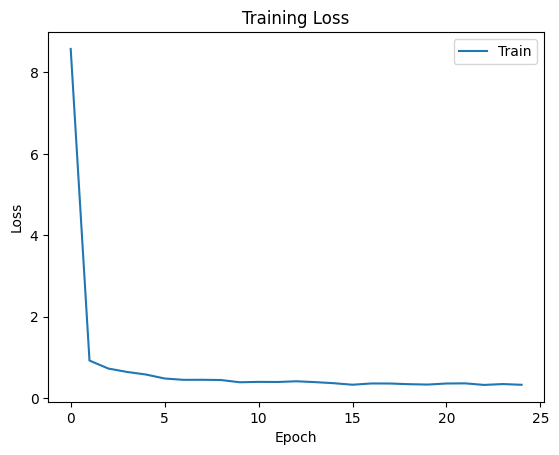

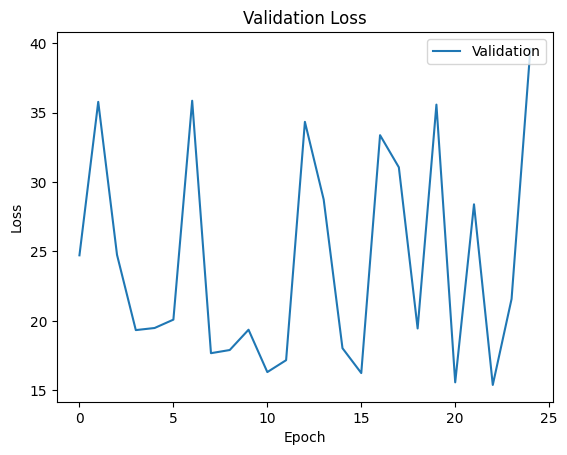

Minimum validation loss: 15.3926


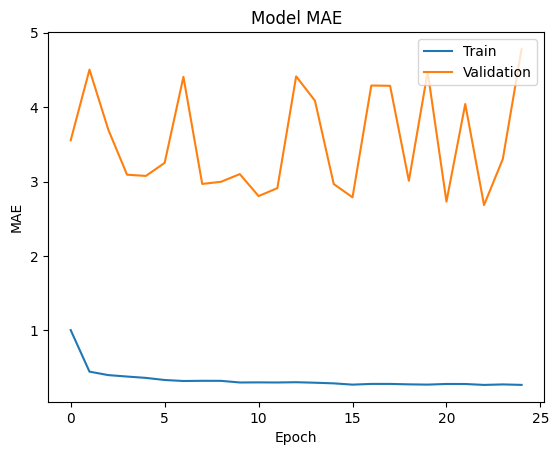

Minimum validation MAE: 2.6844
Minimum validation MAPE: 2.3891


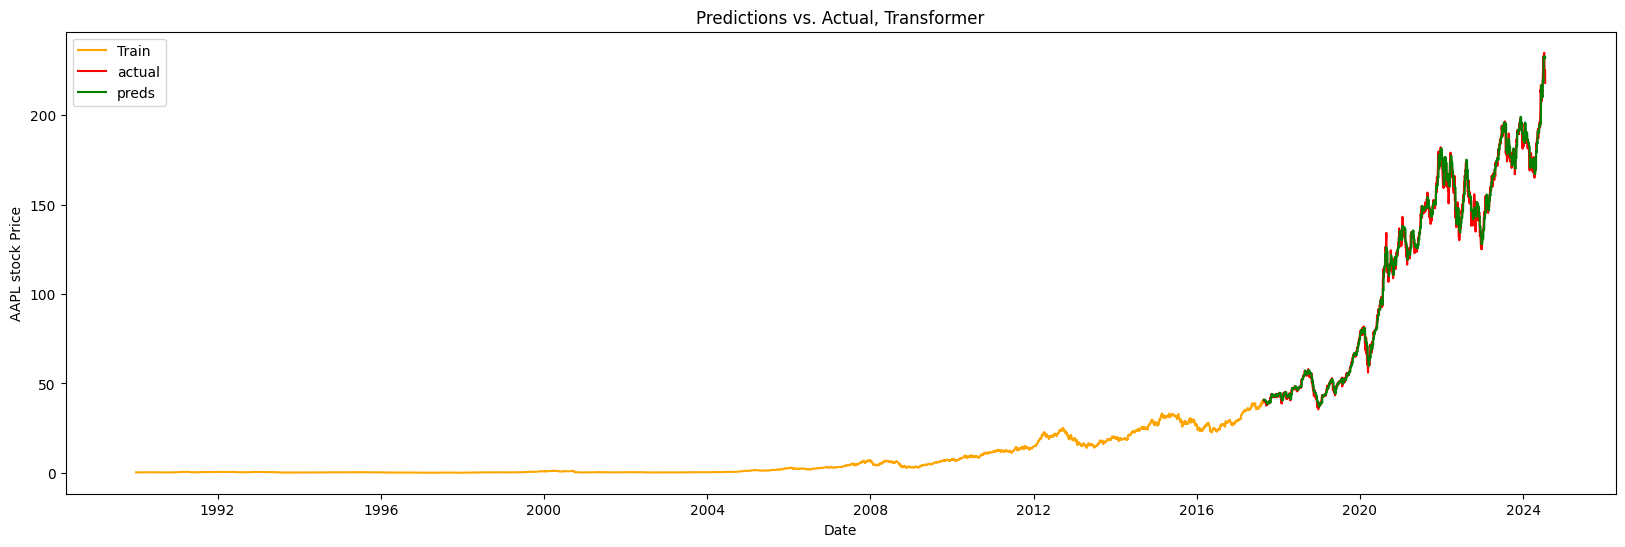

MAPE: 0.023461672827462643
RMSE: 3.8554883666270348
MAE: 2.644298202690037
R-squared: 0.9950927408856047


In [8]:

# ticker = 'NDX'
ticker = 'AAPL'
# timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'))
dataset = dataset[['Close']]

normaliza_bool_update = False
type_normalisation_update = None

data = ETL(datainput=dataset, test_size=0.2, n_input=5, timestep=5,
           normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)

transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[
                                256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
# transformer.summary()
# train the model
# hist = fit_transformer(transformer)
hist = fit_transformer(transformer, data.X_train,
                       data.y_train, data.X_test, data.y_test, display_loss=True)
# time used

transformer_preds = PredictAndForecast(transformer, data.train, data.test, n_input=5,
                                       scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)

plot_results(data.train, data.test, transformer_preds.predictions,
             data.df, title_suffix='Transformer')
train_evaluation = Evaluate(data.test, transformer_preds.predictions)
print(f"MAPE: {train_evaluation.mape}")
print(f"RMSE: {train_evaluation.rmse}")
print(f"MAE: {train_evaluation.mae}")
print(f"R-squared: {train_evaluation.r2}")

EMA data

[*********************100%%**********************]  1 of 1 completed

(1393, 5, 1)
(348, 5, 1)
[[[ 0.332589  ]
  [ 0.33299482]
  [ 0.33352994]
  [ 0.33417068]
  [ 0.33510074]]

 [[ 0.33299482]
  [ 0.33352994]
  [ 0.33417068]
  [ 0.33510074]
  [ 0.33525297]]

 [[ 0.33352994]
  [ 0.33417068]
  [ 0.33510074]
  [ 0.33525297]
  [ 0.33273952]]

 ...

 [[38.2267599 ]
  [38.49507617]
  [38.77233513]
  [39.04372863]
  [39.00486921]]

 [[38.49507617]
  [38.77233513]
  [39.04372863]
  [39.00486921]
  [39.07125643]]

 [[38.77233513]
  [39.04372863]
  [39.00486921]
  [39.07125643]
  [39.233301  ]]] [[ 0.33525297  0.33273952  0.32824797  0.32457307  0.32116051]
 [ 0.33273952  0.32824797  0.32457307  0.32116051  0.31938296]
 [ 0.32824797  0.32457307  0.32116051  0.31938296  0.31529061]
 ...
 [39.07125643 39.233301   39.44542837 39.58944125 39.5668156 ]
 [39.233301   39.44542837 39.58944125 39.5668156  39.53194003]
 [39.44542837 39.58944125 39.5668156  39.53194003 39.49022397]]
[[[ 39.64965382]
  [ 39.6801715 ]
  [ 39.73195853]
  [ 39.84751158]
  [ 40.00750964]]

 [[ 39


/var/folders/jb/ggq229g94ql147w8sftb9qs80000gn/T/ipykernel_64878/8588721.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['EMA'] = dataset['Close'].ewm(span=period, adjust=False).mean()


218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 31.0397 - mae: 2.1760 - mape: 75.7464 - val_loss: 15.2408 - val_mae: 2.8857 - val_mape: 2.5510
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.8948 - mae: 0.4359 - mape: 10.1363 - val_loss: 24.3367 - val_mae: 3.6197 - val_mape: 3.1918
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6653 - mae: 0.3826 - mape: 11.7254 - val_loss: 10.1803 - val_mae: 2.3033 - val_mape: 2.0652
Epoch 4/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5576 - mae: 0.3525 - mape: 11.6286 - val_loss: 14.5258 - val_mae: 2.9152 - val_mape: 2.6395
Epoch 5/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4771 - mae: 0.3243 - mape: 10.7812 - val_loss: 12.0168 - val_mae: 2.6578 - val_mape: 2.4038
Epoch 6/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3687 - mae: 0.2907 - mape: 10.1948 - val_loss: 10.7585 - val_mae: 2.3834 - val_mape: 2.1621
Epoch 7/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3714 - mae: 0.2967 - 

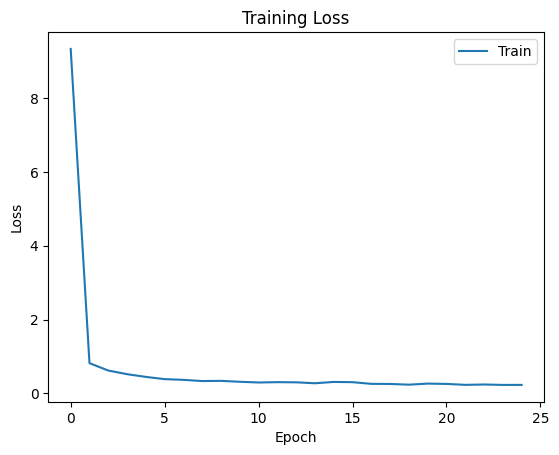

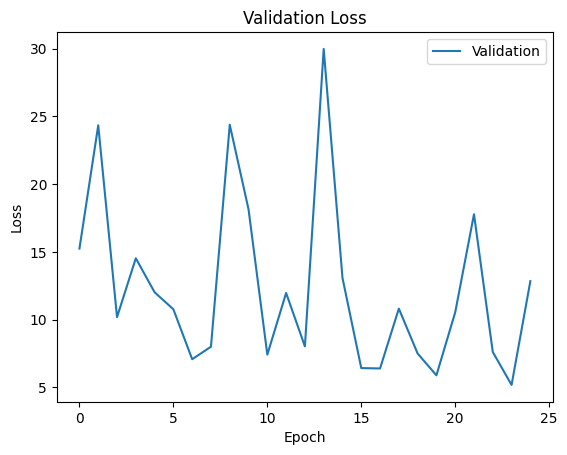

Minimum validation loss: 5.1795


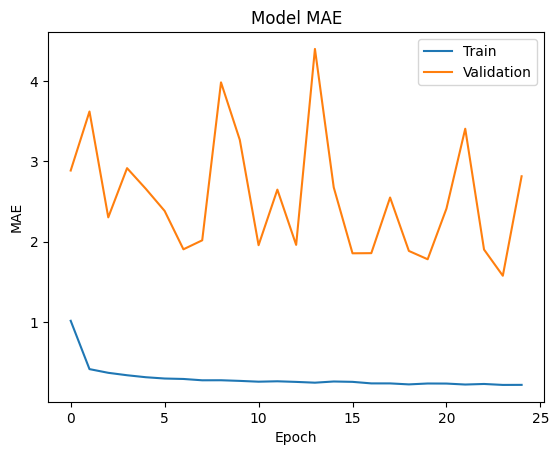

Minimum validation MAE: 1.5775
Minimum validation MAPE: 1.4082


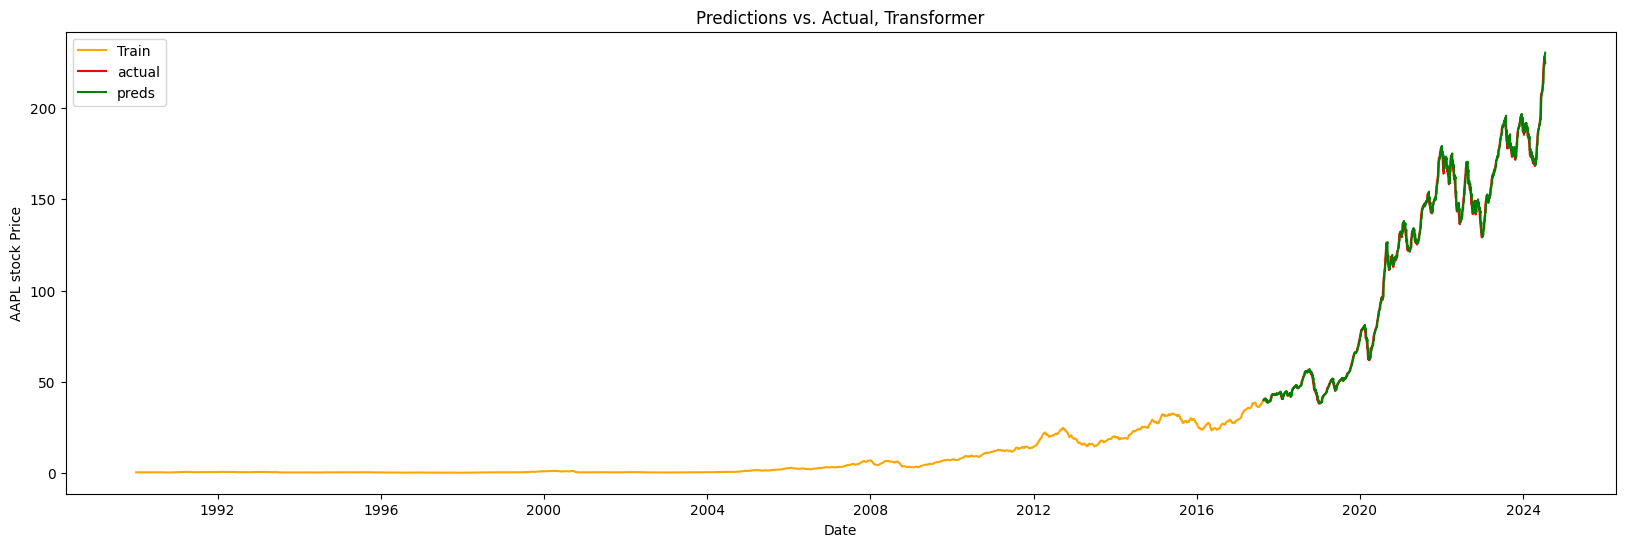

MAPE: 0.014046495000776508
RMSE: 2.2936258179024085
MAE: 1.5787992545896627
R-squared: 0.99824590356226


In [13]:

period = 10  # 15 days moving average

ticker = 'AAPL'
# timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'))
dataset = dataset[['Close']]
dataset['EMA'] = dataset['Close'].ewm(span=period, adjust=False).mean()

normaliza_bool_update = False
type_normalisation_update = None

data = ETL(datainput=dataset['EMA'].dropna(), test_size=0.2, n_input=5, timestep=5,
           normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)

transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[
                                256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)

# train the model
hist = fit_transformer(transformer, data.X_train,
                       data.y_train, data.X_test, data.y_test, display_loss=False)
# time used

transformer_preds = PredictAndForecast(transformer, data.train, data.test, n_input=5,
                                       scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)

plot_results(data.train, data.test, transformer_preds.predictions,
             data.df, title_suffix='Transformer')
train_evaluation = Evaluate(data.test, transformer_preds.predictions)
print(f"MAPE: {train_evaluation.mape}")
print(f"RMSE: {train_evaluation.rmse}")
print(f"MAE: {train_evaluation.mae}")
print(f"R-squared: {train_evaluation.r2}")

[*********************100%%**********************]  1 of 1 completed

(1391, 5, 1)
(347, 5, 1)
[[[ 0.3152905 ]
  [ 0.3121655 ]
  [ 0.3079244 ]
  [ 0.3044645 ]
  [ 0.3026787 ]]

 [[ 0.3121655 ]
  [ 0.3079244 ]
  [ 0.3044645 ]
  [ 0.3026787 ]
  [ 0.3023439 ]]

 [[ 0.3079244 ]
  [ 0.3044645 ]
  [ 0.3026787 ]
  [ 0.3023439 ]
  [ 0.3007814 ]]

 ...

 [[38.50725021]
  [38.69724998]
  [38.81625023]
  [39.01575012]
  [39.29375038]]

 [[38.69724998]
  [38.81625023]
  [39.01575012]
  [39.29375038]
  [39.58250046]]

 [[38.81625023]
  [39.01575012]
  [39.29375038]
  [39.58250046]
  [39.6777504 ]]] [[ 0.3023439   0.3007814   0.2998885   0.2991072   0.2997768 ]
 [ 0.3007814   0.2998885   0.2991072   0.2997768   0.3008928 ]
 [ 0.2998885   0.2991072   0.2997768   0.3008928   0.3008928 ]
 ...
 [39.58250046 39.6777504  39.73500023 39.76275024 39.72275047]
 [39.6777504  39.73500023 39.76275024 39.72275047 39.7152504 ]
 [39.73500023 39.76275024 39.72275047 39.7152504  39.68825035]]
[[[ 39.97975044]
  [ 40.13325043]
  [ 40.2970005 ]
  [ 40.41875038]
  [ 40.4720005 ]]

 [[ 40


/var/folders/jb/ggq229g94ql147w8sftb9qs80000gn/T/ipykernel_64878/3125371252.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['SMA'] = dataset.rolling(window=period).mean()


218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 24.3681 - mae: 2.0330 - mape: 106.3209 - val_loss: 14.2080 - val_mae: 2.8004 - val_mape: 2.4919
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9632 - mae: 0.4444 - mape: 10.1376 - val_loss: 11.2058 - val_mae: 2.4266 - val_mape: 2.1619
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.7102 - mae: 0.3950 - mape: 11.6728 - val_loss: 12.4811 - val_mae: 2.5556 - val_mape: 2.2837
Epoch 4/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.5238 - mae: 0.3460 - mape: 10.7516 - val_loss: 12.4858 - val_mae: 2.6541 - val_mape: 2.3980
Epoch 5/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4979 - mae: 0.3451 - mape: 11.7683 - val_loss: 23.5198 - val_mae: 3.6222 - val_mape: 3.2256
Epoch 6/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4900 - mae: 0.3396 - mape: 12.2344 - val_loss: 8.8105 - val_mae: 2.1890 - val_mape: 1.9726
Epoch 7/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3716 - mae: 0.2917 

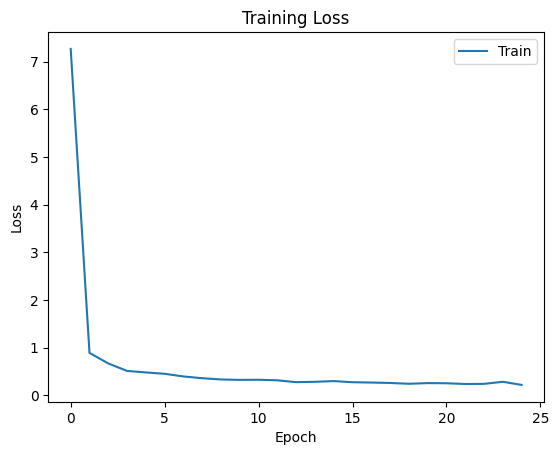

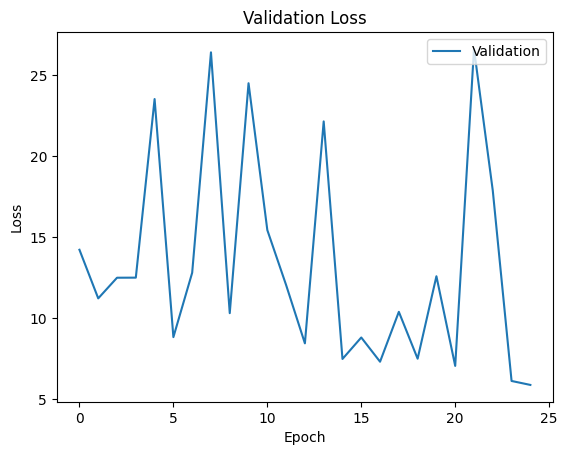

Minimum validation loss: 5.8584


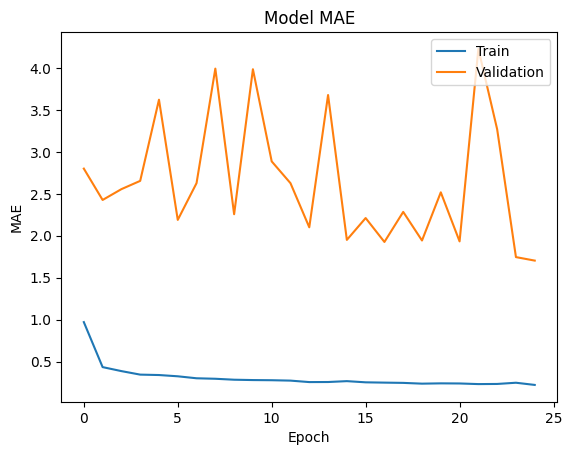

Minimum validation MAE: 1.7036
Minimum validation MAPE: 1.5245


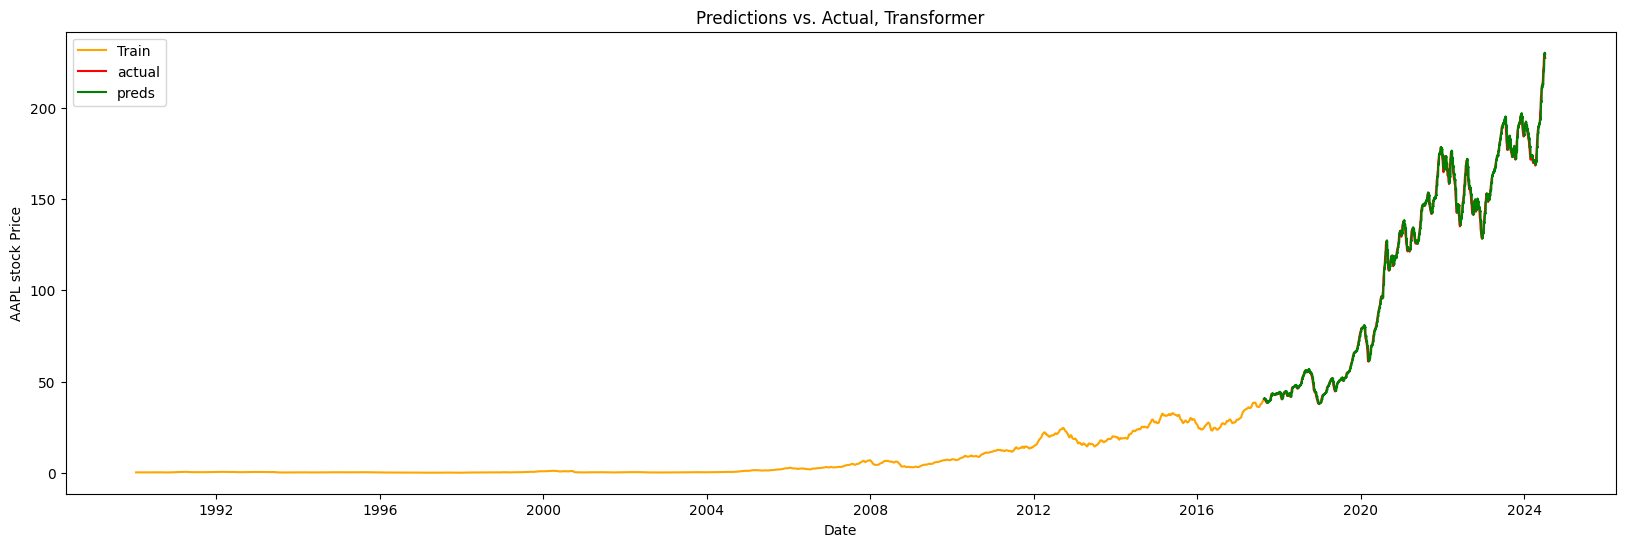

MAPE: 0.015212745666494042
RMSE: 2.4182184094516326
MAE: 1.6964643758724334
R-squared: 0.9980482577767482


In [14]:

period = 10  # 10 days moving average

ticker = 'AAPL'
# timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'))
dataset = dataset[['Close']]
dataset['SMA'] = dataset.rolling(window=period).mean()

normaliza_bool_update = False
type_normalisation_update = None

data = ETL(datainput=dataset['SMA'].dropna(), test_size=0.2, n_input=5, timestep=5,
           normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)

transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[
                                256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)

# train the model
hist = fit_transformer(transformer, data.X_train,
                       data.y_train, data.X_test, data.y_test, display_loss=False)
# time used

transformer_preds = PredictAndForecast(transformer, data.train, data.test, n_input=5,
                                       scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)

plot_results(data.train, data.test, transformer_preds.predictions,
             data.df, title_suffix='Transformer')
train_evaluation = Evaluate(data.test, transformer_preds.predictions)
print(f"MAPE: {train_evaluation.mape}")
print(f"RMSE: {train_evaluation.rmse}")
print(f"MAE: {train_evaluation.mae}")
print(f"R-squared: {train_evaluation.r2}")

including Normalization Maxmin

[*********************100%%**********************]  1 of 1 completed

(1393, 5, 1)
(348, 5, 1)
[[[0.00092489]
  [0.0009344 ]
  [0.00093916]
  [0.00094391]
  [0.00095342]]

 [[0.0009344 ]
  [0.00093916]
  [0.00094391]
  [0.00095342]
  [0.00093916]]

 [[0.00093916]
  [0.00094391]
  [0.00095342]
  [0.00093916]
  [0.00087734]]

 ...

 [[0.16608965]
  [0.16866736]
  [0.17002012]
  [0.17106399]
  [0.16494993]]

 [[0.16866736]
  [0.17002012]
  [0.17106399]
  [0.16494993]
  [0.16725068]]

 [[0.17002012]
  [0.17106399]
  [0.16494993]
  [0.16725068]
  [0.16977514]]] [[0.00093916 0.00087734 0.00082028 0.00082028 0.00081077]
 [0.00087734 0.00082028 0.00082028 0.00081077 0.00083454]
 [0.00082028 0.00082028 0.00081077 0.00083454 0.00077272]
 ...
 [0.16725068 0.16977514 0.17163919 0.17094682 0.16765545]
 [0.16977514 0.17163919 0.17094682 0.16765545 0.16727199]
 [0.17163919 0.17094682 0.16765545 0.16727199 0.16696309]]
[[[0.1699136 ]
  [0.16915734]
  [0.16978579]
  [0.17150071]
  [0.17303456]]

 [[0.16915734]
  [0.16978579]
  [0.17150071]
  [0.17303456]
  [0.17350323]]


218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 4.7847e-04 - mae: 0.0115 - mape: 4019.9390 - val_loss: 0.0028 - val_mae: 0.0386 - val_mape: 6.7998
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.3559e-05 - mae: 0.0033 - mape: 444.8997 - val_loss: 0.0025 - val_mae: 0.0367 - val_mape: 6.5864
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.5924e-05 - mae: 0.0024 - mape: 268.1732 - val_loss: 0.0018 - val_mae: 0.0309 - val_mape: 5.5070
Epoch 4/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.5237e-05 - mae: 0.0025 - mape: 337.0741 - val_loss: 0.0020 - val_mae: 0.0333 - val_mape: 5.9632
Epoch 5/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1448e-05 - mae: 0.0020 - mape: 165.1256 - val_loss: 0.0020 - val_mae: 0.0335 - val_mape: 6.0723
Epoch 6/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0836e-05 - mae: 0.0021 - mape: 295.2361 - val_loss: 0.0020 - val_mae: 0.0332 - val_mape: 6.0017
Epoch 7/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 

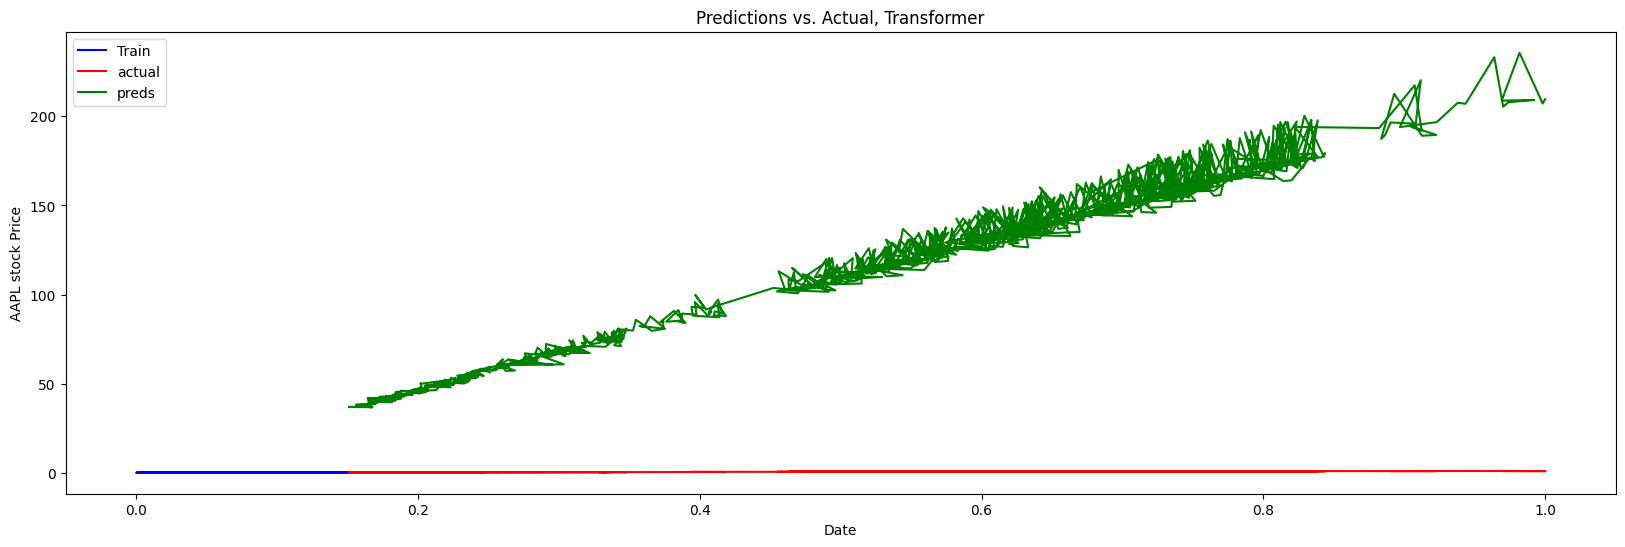

MAPE: 221.67320494436925
RMSE: 116.86164301651642
MAE: 105.6009310416864
R-squared: -248344.47793294364


In [5]:
# ticker = 'NDX'
ticker = 'AAPL'
# timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'))
dataset = dataset[['Close']]

normaliza_bool_update = True
type_normalisation_update = MinMaxScaler()

data1 = ETL(datainput=dataset, test_size=0.2, n_input=5, timestep=5,
            normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)

transformer1 = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[
    256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
# transformer1.summary()
# train the model
hist = fit_transformer(transformer1, data1.X_train,
                       data1.y_train, data1.X_test, data1.y_test, display_loss=False)

transformer_preds_1 = PredictAndForecast(transformer1, data1.train, data1.test, n_input=5,
                                         scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)

plot_results(data1.train, data1.test, transformer_preds_1.predictions,
             data1.df, title_suffix='Transformer')
train_evaluation = Evaluate(data1.test, transformer_preds_1.predictions)
print(f"MAPE: {train_evaluation.mape}")
print(f"RMSE: {train_evaluation.rmse}")
print(f"MAE: {train_evaluation.mae}")
print(f"R-squared: {train_evaluation.r2}")

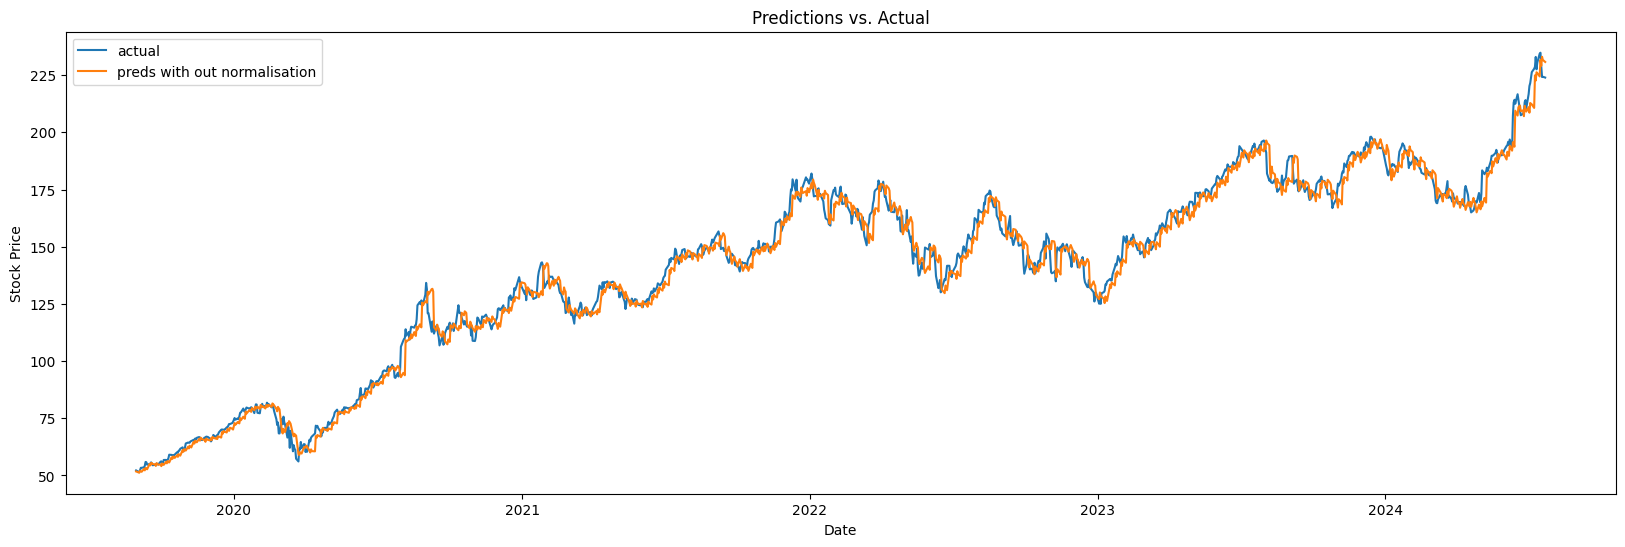

In [ ]:
# plot_results(data.test, transformer_preds.predictions, data.df, title_suffix='Transformer')

fig, ax = plt.subplots(figsize=(20, 6))
# x = df.Close[-498:].index
plot_test = data.test[1:]
plot_preds = transformer_preds.predictions[1:]
x = data.df[-(plot_test.shape[0]*plot_test.shape[1]):].index
plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
ax.plot(x, plot_test, label='actual')
ax.plot(x, plot_preds, label='preds with out normalisation')
ax.set_title(f'Predictions vs. Actual')
ax.set_xlabel('Date')
ax.set_ylabel("Stock Price")
ax.legend()
plt.show()